In [1]:
# syft absolute
import syft as sy
from syft import ActionObject
from syft.client.syncing import compare_states

In [2]:
# stdlib

# third party
from IPython.display import display

In [3]:
# syft absolute
from syft import SyftSuccess
from syft.client.syncing import resolve_single

In [4]:
node_low = sy.orchestra.launch(
    name="test_l",
    node_side_type="low",
    dev_mode=True,
    reset=True,
    local_db=True,
    n_consumers=1,
    create_producer=True,
)

node_high = sy.orchestra.launch(
    name="test_h",
    node_side_type="high",
    dev_mode=True,
    reset=True,
    local_db=True,
    n_consumers=1,
    create_producer=True,
)

Staging Protocol Changes...
Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=1 image_uid=2948bfd0b7d943faa563aad324db0284 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Staging Protocol Changes...
Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=1 image_uid=3a9c886e071547bf934ae48d441013af in_memory=True
Created default worker pool.
Data Migrated to latest version !!!


02/04/24 15:56:14 FUNCTION LOG (92c22d0747b9414989ed8659132909bf): Computing mean...


In [5]:
client_low = node_low.login(email="info@openmined.org", password="changethis")
client_high = node_high.login(email="info@openmined.org", password="changethis")

Logged into <test_l: Low side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Logged into <test_h: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

In [6]:
client_low.register(
    email="newuser@openmined.org", name="John Doe", password="pw", password_verify="pw"
)

SyftSuccess: User 'John Doe' successfully registered! To see users, run `[your_client].users`

In [7]:
client_low_ds = node_low.login(email="newuser@openmined.org", password="pw")

Logged into <test_l: Low side Domain> as <newuser@openmined.org>


# Create datasets

In [8]:
# third party
import numpy as np

In [9]:
mock_high = np.array([10, 11, 12, 13, 14])
private_high = np.array([15, 16, 17, 18, 19])

dataset_high = sy.Dataset(
    name="my-dataset",
    description="abc",
    asset_list=[
        sy.Asset(
            name="numpy-data",
            mock=mock_high,
            data=private_high,
            shape=private_high.shape,
            mock_is_real=True,
        )
    ],
)

client_high.upload_dataset(dataset_high)


  0%|                                                             | 0/1 [00:00<?, ?it/s]

Uploading: numpy-data


100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.27it/s]


SyftSuccess: Dataset uploaded to 'test_h'. To see the datasets uploaded by a client on this node, use command `[your_client].datasets`

In [10]:
mock_low = np.array([0, 1, 2, 3, 4])  # do_high.mock
# private_low = np.array([5, 6, 7, 8, 9])  # AOEmpty? create new type AO

dataset_low = sy.Dataset(
    id=dataset_high.id,
    name="my-dataset",
    description="abc",
    asset_list=[
        sy.Asset(
            name="numpy-data",
            mock=mock_low,
            data=ActionObject.empty(data_node_id=client_high.id),
            shape=mock_low.shape,
            mock_is_real=True,
        )
    ],
)

res = client_low.upload_dataset(dataset_low)

100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.84it/s]


Uploading: numpy-data


In [11]:
dataset_storage_permissions = node_low.python_node.get_service(
    "datasetservice"
).stash.partition.storage_permissions
dataset_id = client_low.datasets[0].id

assert dataset_storage_permissions[dataset_id] == {node_low.python_node.id}

# Data Scientist: make requests

<DomainClient: test_l>
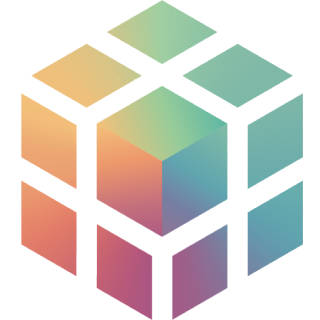

In [12]:
client_low_ds

In [13]:
data_low = client_low_ds.datasets[0].assets[0]


@sy.syft_function_single_use(data=data_low)
def compute_mean(data) -> float:
    print("Computing mean...")
    return data.mean()


compute_mean(data=data_low.mock)

SyftSuccess: Syft function 'compute_mean' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=5baf71204e8744a9a946ed8a8abe6f59 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_compute_mean_1317: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Approving request for domain ephemeral_node_compute_mean_1317
Computing mean...
SyftInfo: Landing the ephmeral node...


```python
Pointer
```
2.0

SyftInfo: Node Landed!


In [14]:
req = client_low_ds.code.request_code_execution(compute_mean)

In [15]:
client_low_ds.code.compute_mean(data=data_low)

SyftError: Execution denied, Please wait for the code to be approved

## Data Owner: Sync to high side

In [16]:
low_state = client_low.get_sync_state()
high_state = client_high.get_sync_state()

In [17]:
low_state

syft.service.sync.sync_state.SyncState

In [18]:
# x = low_state.rows[0].object.status

### Diff state

In [19]:
diff_state = compare_states(low_state, high_state)

In [20]:
diff_state

syft.service.sync.diff_state.NodeDiff

### Resolve

In [21]:
obj_diff_batch = diff_state[0]

In [22]:
widget = resolve_single(obj_diff_batch)

In [23]:
widget

In [24]:
widget.click_sync()

Decision: Syncing 2 objects


SyftSuccess: Synced 2 items

### Sync second batch

In [25]:
obj_diff_batch_request = diff_state[1]

In [26]:
widget = resolve_single(obj_diff_batch_request)

In [27]:
widget

In [28]:
widget.click_sync()

Decision: Syncing 1 objects


SyftSuccess: Synced 1 items

# Run code on high side

In [29]:
# TODO: FIX
client_high._fetch_api(client_high.credentials)

In [30]:
data_high = client_high.datasets[0].assets[0]

In [31]:
job_high = client_high.code.compute_mean(data=data_high, blocking=False)
display(job_high)

```python
class Job:
    id: UID = 92c22d0747b9414989ed8659132909bf
    status: JobStatus.CREATED
    has_parent: False
    result: syft.service.action.action_data_empty.ObjectNotReady
    logs:

0 
    
```

In [32]:
# wait for the result
job_high.wait().get()

17.0

In [33]:
job_info = job_high.info(public_metadata=True, result=True)

request = client_high.requests[0]
result_obj = job_high.result

In [34]:
job_info

syft.service.job.job_stash.JobInfo

In [35]:
accept_res = request.accept_by_depositing_result(job_info)

assert isinstance(accept_res, SyftSuccess)
accept_res

Approving request for domain test_h
returning existing job
setting permission
None
None
Approving request for domain test_h
ADDING PERMISSION [READ: 77701cc5806741e89f0321ab266407f5 as f9d153d952491952afe1a436438a62d14c40feae677da8c04746c3957cc523c0] 77701cc5806741e89f0321ab266407f5
Job(92c22d0747b9414989ed8659132909bf) Setting new result 77701cc5806741e89f0321ab266407f5 -> 77701cc5806741e89f0321ab266407f5


SyftSuccess: Request submitted for updating result.

## Assertions

In [36]:
# Need to refresh Job because we overwrite result
job_high = client_high.jobs[0]

action_store_high = node_high.python_node.get_service("actionservice").store
blob_store_high = node_high.python_node.get_service(
    "blobstorageservice"
).stash.partition
assert (
    f"{client_low_ds.verify_key}_READ"
    in action_store_high.permissions[job_high.result.id.id]
)
assert (
    f"{client_low_ds.verify_key}_READ"
    in blob_store_high.permissions[job_high.result.syft_blob_storage_entry_id]
)

In [37]:
assert action_store_high.storage_permissions[job_high.result.id.id] == {
    node_high.python_node.id
}

## Data Owner: Sync back to low-side

In [38]:
low_state = client_low.get_sync_state()
high_state = client_high.get_sync_state()

In [39]:
high_state

syft.service.sync.sync_state.SyncState

In [40]:
diff_state_2 = compare_states(high_state, low_state)

In [41]:
diff_state_2

syft.service.sync.diff_state.NodeDiff

### Syc code

In [42]:
code_batch = diff_state_2[0]

In [43]:
widget = resolve_single(code_batch)
widget

In [44]:
res = widget.click_sync()

Decision: Syncing 2 objects


### Sync job

In [45]:
job_batch = diff_state_2[2]

In [46]:
widget = resolve_single(job_batch)
widget

In [47]:
res = widget.click_share_all_private_data()

In [48]:
res = widget.click_sync()

Decision: Syncing 4 objects


In [49]:
res

SyftSuccess: Synced 4 items

In [54]:
action_store_low = node_low.python_node.get_service("actionservice").store
blob_store_low = node_low.python_node.get_service("blobstorageservice").stash.partition
assert (
    f"{client_low_ds.verify_key}_READ"
    in action_store_low.permissions[job_high.result.id.id]
)
assert (
    f"{client_low_ds.verify_key}_READ"
    in blob_store_low.permissions[job_high.result.syft_blob_storage_entry_id]
)

In [55]:
result_storage_permissions = node_low.python_node.get_service(
    "actionservice"
).store.storage_permissions[job_high.result.id.id]
assert len(result_storage_permissions) == 1

log_storage_permissions = node_low.python_node.get_service(
    "logservice"
).stash.partition.storage_permissions[job_high.log_id]
assert len(log_storage_permissions) == 1

# Run code low

## Run

In [56]:
client_low_ds._fetch_api(client_low_ds.credentials)

In [57]:
# client_low_ds.code.compute_mean.jobs

In [58]:
res_low = client_low_ds.code.compute_mean(data=data_low)

res_low

SyftWarning: Policy is no longer valid. count: 1 >= limit: 1. Loading results from cache.

```python
Pointer
```
17.0

In [59]:
code = client_low_ds.code[0]

assert res_low.get() == private_high.mean()
assert (
    res_low.id.id
    == job_high.result.id.id
    == code.output_history[-1].output_ids[0].id.id
)
assert job_high.result.syft_blob_storage_entry_id == res_low.syft_blob_storage_entry_id

In [60]:
res_low = client_low_ds.code.compute_mean(data=data_low)

res_low

SyftWarning: Policy is no longer valid. count: 1 >= limit: 1. Loading results from cache.

```python
Pointer
```
17.0

In [61]:
code = client_low_ds.code[0]

assert res_low.get() == private_high.mean()
assert (
    res_low.id.id
    == job_high.result.id.id
    == code.output_history[-1].output_ids[0].id.id
)
assert job_high.result.syft_blob_storage_entry_id == res_low.syft_blob_storage_entry_id

In [62]:
private_high.mean()

17.0

In [63]:
job_low = client_low_ds.code.compute_mean(data=data_low, blocking=False)
job_low

SyftWarning: There are existing jobs for this user code, returning the latest one

```python
class Job:
    id: UID = d718e4c2ee5a4ddc91bf54aabfc8c865
    status: JobStatus.COMPLETED
    has_parent: False
    result: ActionDataEmpty <<class 'numpy.number'>>
    logs:

0 Computing mean...
JOB COMPLETED
    
```

In [64]:
job_low.wait().get()

17.0

In [65]:
job_low.logs()

Computing mean...



In [66]:
assert job_low.id == job_high.id
assert job_low.result.id == job_high.result.id
assert (
    job_low.result.syft_blob_storage_entry_id
    == job_high.result.syft_blob_storage_entry_id
)

In [67]:
job_high

```python
class Job:
    id: UID = d718e4c2ee5a4ddc91bf54aabfc8c865
    status: JobStatus.COMPLETED
    has_parent: False
    result: 17.0
    logs:

0 Computing mean...
JOB COMPLETED
    
```